<a href="https://colab.research.google.com/github/dhkim0821/Cheetah-Vision-Realsense/blob/master/CS690K_2023_Fall/casadi_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CASADI Examples**

In [1]:
!pip3 install sympy seaborn ffmpeg-python qpsolvers casadi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.7/83.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.0/459.0 kB 34.7 MB/s eta 0:00:00


In [ ]:
import sympy as sym
from sympy import Symbol, simplify, lambdify
from sympy.matrices.expressions import transpose
from sympy import sin, cos, Matrix
import numpy as np
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation
%matplotlib inline

# Declare Symbolic Variables

In [ ]:
# Write your code: Symbolic variable definition. Complete the following variable list
[m_body, m1, m2, m3, I_body, I1, I2, I3, l0, l1, l2, l3, c1, c2,c3,g] = sym.symbols('M m1 m2 m3 I I1 I2 I3 l0 l1 l2 l3 c1 c2 c3 g')
[x, y, thb, th1, th2, th3, dx, dy, dthb, dth1, dth2, dth3, ddx, ddy, ddthb, ddth1, ddth2, ddth3] = sym.symbols('x y thb th1 th2 th3 dx dy dthb dth1 dth2 dth3 ddx ddy ddthb ddth1 ddth2 ddth3')
[tau1, tau2, tau3] = sym.symbols('tau1 tau2 tau3')

# Symbolic variable groupings: No need to change
q  = Matrix([x, y, thb, th1,  th2, th3])
dq = Matrix([dx, dy, dthb, dth1, dth2, dth3])
ddq= Matrix([ddx, ddy, ddthb, ddth1, ddth2, ddth3])
u  = Matrix([tau1, tau2, tau3]) # control input
z = Matrix([q.transpose(), dq.transpose()]) # state
p   = [m_body, m1, m2, m3, I_body, I1, I2, I3, l0, l1, l2, l3, c1, c2, c3, g]  # parameters

zp_params = list(z)+list(p)
zup_params = list(z)+list(u)+list(p)

# Parameters: No need to change
m_body_p  = 3.
m1_p = 1.5
m2_p = 1.
m3_p = 2.0
l0_p = .3
l1_p = .6
l2_p = .6
l3_p = .5
c1_p = .3
c2_p = .2
c3_p = .4
I_body_p = 0.01
I1_p = 0.005
I2_p = 0.005
I3_p = 0.009
g_p  = 9.81

params   = [m_body_p, m1_p, m2_p, m3_p, I_body_p, I1_p, I2_p, I3_p, l0_p, l1_p, l2_p, l3_p, c1_p, c2_p, c3_p, g_p]

In [ ]:
# Handy functions to be used to compute time derivative and generalized forces: No need to change
ddt = lambda x: x.jacobian(q)@dq + x.jacobian(dq)@ddq        # Time derivative
F2Q = lambda F, r : simplify(r.jacobian(q).transpose()*F)    # force contributions to generalized forces
M2Q = lambda M, w : simplify(w.jacobian(dq).transpose()*M)   # moment contributions to generalized forces

# **Kinemeatics**
The robot's body angle and joint angles are described in the figure:

<img src="https://github.com/DARoSLab/Adv_robot_dyn_ctrl/blob/main/Figures/Leg_kin.png?raw=true" height="430">

In [ ]:
# Kinemeatics
r0 = Matrix([x, y])    # position of link 1
ehat1 = Matrix([sin(thb), -cos(thb)]) # Define unit vector along Leg 1
ehat2 = Matrix([sin(thb+th1), -cos(thb+th1)])  # Define unit vector along Leg 2
ehat3 = Matrix([sin(thb+th1+th2), -cos(thb+th1+th2)])  # Define unit vector along Leg 2
ehat4 = Matrix([cos(thb+th1+th2+th3), sin(thb+th1+th2+th3)])  # Define unit vector along Leg 2
ehat5 = -ehat4  # Define unit vector along Leg 2
ghat  = Matrix([0, -1 ])

# CoM position and link position
rA  = r0 + l0*ehat1          # Position of base of link 2
rB  = rA + l1*ehat2     # Position of end of link 3
rC  = rB + l2*ehat3     # Position of end of link 3
rD  = rC + 0.5*l3*ehat4     # Position of Heel
rE  = rC + 0.5*l3*ehat5     # Position of Toe

rcb  = r0 # COM of base
rc1 = rA + c1*ehat2          # Position of link 1 CoM
rc2 = rB + c2*ehat3     # Position of CoM of link 2
rc3 = rC     # Position of CoM of link 3


# linear and angular velocity of each link
vcb = ddt(rcb)
vc1 = ddt(rc1)          # Velocity of link 1 CoM
vc2 = ddt(rc2)          # Velocity of link 2 CoM
vc3 = ddt(rc3)          # Velocity of link 3 CoM

keypoints = Matrix([[r0], [rA], [rB], [rC], [rD], [rE]]).reshape(6, 2)
keypoints_func = sym.lambdify(zp_params, keypoints)

In [ ]:
# hopper robot visualization function:
import matplotlib.patches as patches
def rotate_rect(rect, angle):
    """Rotate the given rectangle around its center and return a rotated copy.

    angle is given in degrees.
    """
    rect = np.array(rect, dtype=np.float64)
    rot_mat = np.array([[np.cos(angle), -np.sin(angle)],
                        [np.sin(angle), np.cos(angle)]])
    rect_rot = np.dot(rot_mat, rect.T).T
    return rect_rot

def get_body_points(x, y, angle, body_width, body_height):
  body_pts = [[-body_width/2, -body_height/2],
              [-body_width/2, body_height/2],
              [body_width/2, body_height/2],
              [body_width/2, -body_height/2]]
  body_pts = rotate_rect(body_pts, angle)
  body_pts_full = np.zeros((5, 2))
  body_pts[:, 0] += x
  body_pts[:, 1] += y
  body_pts_full[:4, :] = body_pts
  body_pts_full[4, :] = body_pts[0]
  return body_pts_full

def visualize_robot(result, dt = 0.001, num_frames=200):
  keypoints_hist = result['keypoints_hist']
  ori_hist = result['ori_hist']
  fig= plt.figure(figsize=(10,10))
  ax = plt.subplot(1,1,1)
  keypoints = keypoints_hist[0]
  keypts = keypoints_hist[0]
  body_width = 2*np.sqrt((keypts[1, 0] - keypts[0, 0])**2 + (keypts[1, 1] - keypts[0, 1])**2)
  body_pts = get_body_points(keypts[0, 0], keypts[0, 1], 0.5, body_width, body_width)
  body, = ax.plot(body_pts[:, 0], body_pts[:, 1], 'g', lw=10, alpha=0.3)
  bodyCOM, = ax.plot(keypts[0, 0], keypts[0, 1], 'go', alpha=0.5, markersize=20)
  link2, = ax.plot([], [], 'r', lw=10, alpha=0.3)
  link3, = ax.plot([], [], 'r', lw=10, alpha=0.3)
  link4, = ax.plot([], [], 'b', lw=10, alpha=0.3)
  ax.hlines(0, -2, 2)
  txt_title = ax.set_title('')
  ax.set_xlim(( -2, 2))
  ax.set_ylim((-1, 3))
  txt_title = ax.set_title('')
  interval = len(keypoints_hist)//num_frames

  def drawFrame(k):
    k = interval*k
    keypts = keypoints_hist[k]
    body_pts = get_body_points(keypts[0, 0], keypts[0, 1], ori_hist[k], body_width, body_width)
    body.set_data(body_pts[:, 0], body_pts[:, 1])
    bodyCOM.set_data(keypts[0, 0], keypts[0, 1])
    x1 = keypts[1, 0]
    x2 = keypts[2, 0]
    y1 = keypts[1, 1]
    y2 = keypts[2, 1]
    link2.set_data([x1, x2], [y1, y2])
    x1 = keypts[2, 0]
    x2 = keypts[3, 0]
    y1 = keypts[2, 1]
    y2 = keypts[3, 1]
    link3.set_data([x1, x2], [y1, y2])
    x1 = keypts[4, 0]
    x2 = keypts[5, 0]
    y1 = keypts[4, 1]
    y2 = keypts[5, 1]
    link4.set_data([x1, x2], [y1, y2])

    txt_title.set_text(f't = {dt*k:.2f} sec')
    return link2, link3, link4
  anim = animation.FuncAnimation(fig, drawFrame, frames=num_frames, interval=interval, blit=True)
  return anim


# **Kinetic and Potential Energy of Links**


In [ ]:
# Write your code: Kinetic and Potential Energy of floating base

Tb = 1/2 * m_body * vcb.dot(vcb) + 1/2 * I_body * dthb*dthb
Vb = m_body * g * (rcb.dot(-ghat))

# Write your code: Kinetic and Potential Energy of link 1

T1 = 1/2 * m1 * vc1.dot(vc1) + 1/2 * I1 * (dthb+dth1)*(dthb+dth1)
V1 = m1 * g * (rc1.dot(-ghat))

# Write your code: Kinetic and Potential Energy of link 2
T2 = 1/2 * m2 * vc2.dot(vc2) + 1/2 * I2 * (dthb+dth1+dth2)*(dthb+dth1+dth2)
V2 = m2 * g * rc2.dot(-ghat)

# Write your code: Kinetic and Potential Energy of link 3
T3 = 1/2 * m3 * vc3.dot(vc3) + 1/2 * I3 * (dthb+dth1-dth2+dth3)*(dthb+dth1+dth2+dth3)
V3 = m3 * g * rc3.dot(-ghat)

# **Lagrangian and Total Energy (Hamiltonian)**

In [ ]:
# Write your code: Kinetic, Potential, and total energy of the entire system
KE = Tb + T1 + T2 + T3
PE = Vb + V1 + V2 + V3
E = Matrix([KE + PE])

# Write your code: Lagrangian
L = Matrix([KE - PE])

# **Generalized Forces**

The result should be $Q = \begin{pmatrix}0 & 0 & 0 & \tau_1 & \tau_2 & \tau_3\end{pmatrix}^{\top}$.

In [ ]:
Q_tau1 = M2Q(tau1,Matrix([dthb + dth1])) + M2Q(-tau1,Matrix([dthb]))
Q_tau2 = M2Q(tau2,Matrix([dth2 + dth1 + dthb])) + M2Q(-tau2, Matrix([dth1 + dthb]))
Q_tau3 = M2Q(tau3,Matrix([dth3 + dth2 + dth1 + dthb])) + M2Q(-tau3, Matrix([dth1 + dth2 + dthb]))

Q = Q_tau1 + Q_tau2 + Q_tau3

print(Q_tau1)
print(Q_tau2)
print(Q_tau3)

print(Q)

Matrix([[0], [0], [0], [tau1], [0], [0]])
Matrix([[0], [0], [0], [0], [tau2], [0]])
Matrix([[0], [0], [0], [0], [0], [tau3]])
Matrix([[0], [0], [0], [tau1], [tau2], [tau3]])


# **Equations of Motion**

In [ ]:
# Write your code: Find A and b by solving Lagrange's equation
dL_dq = L.jacobian(q).transpose()
dL_dqd= L.jacobian(dq).transpose()

g = ddt(dL_dqd) - dL_dq - Q
A = g.jacobian(ddq)
b = A*ddq - g
grav = (Matrix([PE]).jacobian(q)).transpose()
coriolis = (-b -grav  + Q)

In [ ]:
JToe = rD.jacobian(q)
JToedot = ddt(JToe.reshape(12,1)).reshape(2, 6)

JHeel = rE.jacobian(q)
JHeeldot = ddt(JHeel.reshape(12,1)).reshape(2, 6)

pToe = rD
pHeel = rE
vToe = JToe*dq
vHeel = JHeel*dq

# **Helper Functions**

In [ ]:
# Helper Functions: No need to change
A_func = sym.lambdify(zp_params, A)
b_func = sym.lambdify(zup_params, b)
kinetic_energy_func = sym.lambdify(zp_params, KE)
potential_energy_func = sym.lambdify(zp_params, PE)
E_func = sym.lambdify(zp_params, E)

grav_func = sym.lambdify(zp_params, grav)
coriolis_func = sym.lambdify(zp_params, coriolis)

# Foot contact position, velocity and jacobian
pToe_func = sym.lambdify(zp_params, pToe)
vToe_func = sym.lambdify(zp_params, vToe)

pHeel_func = sym.lambdify(zp_params, pHeel)
vHeel_func = sym.lambdify(zp_params, vHeel)

JToe_func = sym.lambdify(zp_params, JToe)
JToedot_func = sym.lambdify(zp_params, JToedot)

JHeel_func = sym.lambdify(zp_params, JHeel)
JHeeldot_func = sym.lambdify(zp_params, JHeeldot)


#**Dynamics**

A dynamics function returning $\ddot{q}$ by using $A$ and $b$.

In [ ]:
def dynamics(x, params, u=[0, 0, 0]):
  xp_params = list(x) + list(params)
  xup_params = list(x) + u + list(params)
  A_dyn = A_func(*xp_params)
  b_dyn = b_func(*xup_params)

  # Write your code: Computer joint acceleration
  qdd = np.matmul(np.linalg.pinv(A_dyn), b_dyn)
  ddq = qdd.reshape(6)

  return ddq

# **Contact solver**

In [ ]:
def discrete_impact_contact(x, params, rest_coeff, fric_coeff):
    xp_params = list(x) + list(params)

    x_test = x.copy()
    qdot = x[6:].copy()

    # EE position and velocity
    toe_pos = pToe_func(*xp_params)
    toe_vel = vToe_func(*xp_params)
    heel_pos = pHeel_func(*xp_params)
    heel_vel = vHeel_func(*xp_params)

    A = A_func(*xp_params)
    Ainv = np.linalg.inv(A)

    tol = 1e-4
    iter_lim = 20

    if (toe_pos[1] < 0 and heel_pos[1]<0):  # ................... Toe & Heel
      post_impact_vel = np.zeros([4,1])
      post_impact_vel[1] = toe_vel[1]
      post_impact_vel[3] = heel_vel[1]

      if(toe_vel[1] < 0):
        post_impact_vel[1] = -rest_coeff*toe_vel[1]

      if(heel_vel[1]<0):
        post_impact_vel[3] = -rest_coeff*heel_vel[1]

      Jtoe  = JToe_func(*xp_params)
      Jheel  = JHeel_func(*xp_params)

      Jtoe_x = Jtoe[0, :]
      Jtoe_y = Jtoe[1, :]
      Jheel_x = Jheel[0,:]
      Jheel_y = Jheel[1,:]

      lambda_toe_x = 1/(Jtoe_x @ Ainv @ Jtoe_x.T)
      lambda_toe_y = 1/(Jtoe_y @ Ainv @ Jtoe_y.T)

      lambda_heel_x = 1/(Jheel_x @ Ainv @ Jheel_x.T)
      lambda_heel_y = 1/(Jheel_y @ Ainv @ Jheel_y.T)

      Ftoe_x_total = 0
      Ftoe_y_total = 0

      Fheel_x_total = 0
      Fheel_y_total = 0

      Ftoe_x_inc = 1000
      Ftoe_y_inc = 1000

      Fheel_x_inc = 1000
      Fheel_y_inc = 1000

      iter = 0
      while(np.abs(Ftoe_y_inc) > tol or np.abs(Fheel_y_inc) > tol):
        # Vertical (y): Toe
        Ftoe_y_inc = lambda_toe_y * (post_impact_vel[1] - Jtoe_y@qdot)
        next_F_toe_y_total = max(0, Ftoe_y_total + Ftoe_y_inc)
        Ftoe_y_inc = next_F_toe_y_total - Ftoe_y_total
        qdot = qdot + Ainv@(Jtoe_y.T*Ftoe_y_inc)
        Ftoe_y_total += Ftoe_y_inc

        # Vertical (y): Heel
        Fheel_y_inc = lambda_heel_y * (post_impact_vel[3] - Jheel_y@qdot)
        next_F_heel_y_total = max(0, Fheel_y_total + Fheel_y_inc)
        Fheel_y_inc = next_F_heel_y_total - Fheel_y_total
        qdot = qdot + Ainv@(Jheel_y.T*Fheel_y_inc)
        Fheel_y_total += Fheel_y_inc

        # Horizontal (x): Heel
        Fheel_x_inc = lambda_heel_x * (post_impact_vel[2] - Jheel_x@qdot)
        next_Fheel_x_total = max(-fric_coeff*Fheel_y_total, min(Fheel_x_total + Fheel_x_inc, fric_coeff*Fheel_y_total))
        Fheel_x_inc = next_Fheel_x_total - Fheel_x_total
        qdot = qdot + Ainv@(Jheel_x.T*Fheel_x_inc)
        Fheel_x_total += Fheel_x_inc

        # horizontal (x): Toe
        Ftoe_x_inc = lambda_toe_x * (post_impact_vel[0] - Jtoe_x@qdot)
        next_Ftoe_x_total = max(-fric_coeff*Ftoe_y_total, min(Ftoe_x_total + Ftoe_x_inc, fric_coeff*Ftoe_y_total))
        Ftoe_x_inc = next_Ftoe_x_total - Ftoe_x_total
        qdot = qdot + Ainv@(Jtoe_x.T*Ftoe_x_inc)
        Ftoe_x_total += Ftoe_x_inc

        iter += 1
        if(iter > iter_lim):
          break

    elif(toe_pos[1]<0): # ........................................... Toe
      post_impact_vel = np.zeros([2,1])
      post_impact_vel[1] = toe_vel[1]
      if(toe_vel[1] < 0):
        post_impact_vel[1] = -rest_coeff*toe_vel[1]

      J  = JToe_func(*xp_params)
      J_x = J[0, :]
      J_y = J[1, :]
      lambda_x = 1/(J_x @ Ainv @ J_x.T)
      lambda_y = 1/(J_y @ Ainv @ J_y.T)

      Fx_total = 0
      Fy_total = 0
      Fx_inc = 1000
      Fy_inc = 1000

      iter = 0
      while(np.abs(Fy_inc) > tol):
        # vertical (y)
        Fy_inc = lambda_y * (post_impact_vel[1] - J_y@qdot)
        next_Fy_total = max(0, Fy_total + Fy_inc)
        Fy_inc = next_Fy_total - Fy_total
        qdot = qdot + Ainv@(J_y.T*Fy_inc)
        Fy_total += Fy_inc

        # horizontal (y)
        Fx_inc = lambda_x * (post_impact_vel[0] - J_x@qdot)
        next_Fx_total = max(-fric_coeff*Fy_total, min(Fx_total + Fx_inc, fric_coeff*Fy_total))
        Fx_inc = next_Fx_total - Fx_total
        qdot = qdot + Ainv@(J_x.T*Fx_inc)
        Fx_total += Fx_inc

        iter += 1
        if(iter > iter_lim):
          break

    elif(heel_pos[1]<0):             # ...................... Heel only contact
      post_impact_vel = np.zeros([2,1])
      post_impact_vel[1] = heel_vel[1]
      if(heel_vel[1]<0):
        post_impact_vel[1] = -rest_coeff*heel_vel[1]

      J  = JHeel_func(*xp_params)
      J_x = J[0, :]
      J_y = J[1, :]
      lambda_x = 1/(J_x @ Ainv @ J_x.T)
      lambda_y = 1/(J_y @ Ainv @ J_y.T)

      Fx_total = 0
      Fy_total = 0
      Fx_inc = 1000
      Fy_inc = 1000

      iter = 0
      while(np.abs(Fy_inc) > tol):
        # vertical (y)
        Fy_inc = lambda_y * (post_impact_vel[1] - J_y@qdot)
        next_Fy_total = max(0, Fy_total + Fy_inc)
        Fy_inc = next_Fy_total - Fy_total
        qdot = qdot + Ainv@(J_y.T*Fy_inc)
        Fy_total += Fy_inc

        # horizontal (y)
        Fx_inc = lambda_x * (post_impact_vel[0] - J_x@qdot)
        next_Fx_total = max(-fric_coeff*Fy_total, min(Fx_total + Fx_inc, fric_coeff*Fy_total))
        Fx_inc = next_Fx_total - Fx_total
        qdot = qdot + Ainv@(J_x.T*Fx_inc)
        Fx_total += Fx_inc

        iter += 1
        if(iter > iter_lim):
          break

    return qdot

# **Q1. [10 pts] Complete joint PD controller**

Complete joint position feedback controller holding the desired joint position.

In [ ]:
def joint_pd_controller(x, xdes, params, Kp=100, Kd=5):
  # Write your code: Compute torque command using PD feedback cntrol
  u = Kp*(xdes[3:6]-x[3:6]) + Kd*(xdes[3+6:]-x[3+6:])
  return u.tolist()

In [ ]:
# Simulation: No need to change
def run_simulation(x0,  x_des_trj, num_step, dt = 0.001,  restitution_coeff = 0.9, friction_coeff = 1.7, ctrl_function = None):
  num_step = int(np.floor(tf/dt));
  tspan = np.linspace(0, tf, num_step);

  x_out = np.zeros((12,num_step+1));
  x_out[:,0] = x0;
  keypoints_hist = []
  ori_hist = []
  result = {}
  for i in range(num_step):
    xp_params = list(x_out[:, i]) + list(params)
    keypoints_hist.append(keypoints_func(*xp_params))

    u = control_func(x_out[:, i], x_des_trj[:, i], params)

    ddq = dynamics(x_out[:,i], params, u);
    x_out[6:,i+1] = x_out[6:,i] + ddq*dt;
    x = np.zeros(12)

    x[:6] = x_out[:6, i]
    x[6:] = x_out[6:, i+1]

    x_out[6:, i+1] = discrete_impact_contact(x, params, restitution_coeff, friction_coeff)
    x_out[:6,i+1] = x_out[:6,i] + x_out[6:,i+1]*dt;
    ori_hist.append(x_out[2, i])

  result['keypoints_hist'] = keypoints_hist
  result['ori_hist'] = ori_hist
  return result

In [ ]:
# Run simulation: No need to change
x0 = np.array([0, 1.4, 0, 0.8, -1.6, 0.8, 0, 0, 0, 0, 0, 0]).T  # x, y, thb, th1, th2, th3, dx, dy, dthb, dth1, dth2, dth3
dt = 0.001
tf = 2.0
num_step = int(np.floor(tf/dt));
ts = np.linspace(0, tf, num_step)

num_step = int(np.floor(tf/dt));
x_des_trj = np.zeros((12, num_step))
x_des_trj[1, :] = x0[1]
x_des_trj[3, :] = x0[3] # Hip
x_des_trj[4, :] = x0[4] # Knee
x_des_trj[5, :] = x0[5] # Ankle


control_func = lambda x, xdes, params : joint_pd_controller(x, xdes, params, Kp=250, Kd=10)

result_joint = run_simulation(x0,  x_des_trj, num_step, dt = dt, restitution_coeff = 0.0, friction_coeff = 0.7, ctrl_function = None)

In [ ]:
anim = visualize_robot(result_joint, dt = 0.001, num_frames=100)
plt.close()
HTML(anim.to_html5_video())

writervideo = animation.FFMpegWriter(fps=60)
anim.save('robot_drop_jpos.mp4', writer=writervideo)


<ipython-input-6-98053b767229>:53: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  bodyCOM.set_data(keypts[0, 0], keypts[0, 1])
<ipython-input-6-98053b767229>:53: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  bodyCOM.set_data(keypts[0, 0], keypts[0, 1])
<ipython-input-6-98053b767229>:53: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  bodyCOM.set_data(keypts[0, 0], keypts[0, 1])


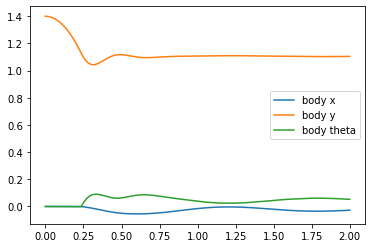

In [ ]:
keypoint_hist_np = np.array(result_joint['keypoints_hist'])

print()
ax = plt.subplot()

ax.plot(ts, keypoint_hist_np[:, 0, 0], label='body x')
ax.plot(ts, keypoint_hist_np[:, 0, 1], label='body y')
ax.plot(ts, result_joint['ori_hist'], label='body theta')
ax.legend()
plt.show()

# **Q2. Wholebody control**

Now we will implement body position and orientation controller using whole-body control formulation. Whole-body control consists of three parts.

The first part is the $\ddot{q}_{\rm cmd}$ computation. Keep it in mind that the dimension of $\ddot{q}_{\rm cmd}$ is 6, including 3-dim floating base (virtual joint) and 3 actuated joints. To compute $\ddot{q}_{\rm cmd}$, we have to use the following equation with a null-space projection matrix:

\begin{equation}
\ddot{q}_{\rm cmd} = \overline{J_{\rm body} N_c} \ddot{x}_{\rm body},
\end{equation}

where $J_{\rm body}$ is the Jacobian of the body link and $\ddot{x}_{\rm body}$ is PD feedback control. $N_c$ is a null space projection matrix, which is defined by $I - \overline{J}_c J_c$. Note that you have to use dynamically consistent pseudo inverse.

\\

The next step is finding reaction forces satisfying unilateral constraints and friction cone constraints. To find the reaction force, you have to solve the following optimization problem:

\begin{align}
& \underset{\Delta\ddot{\mathbf{q}},  \mathbf{fr}}{min}\  ||\Delta\ddot{\mathbf{q}}||_{Q_q} + ||\mathbf{f_r}||_{Q_{fr}} \\
s.t & \\
& S\left( \mathbf{A}\begin{pmatrix} \ddot{\mathbf{q}}_{\rm body} + \Delta \ddot{\mathbf{q}} \\ \ddot{\mathbf{q}}_{\rm joint} \end{pmatrix}+ \mathbf{b} + \mathbf{g} \right) = S \mathbf{J_c}^{\top}\mathbf{f_r}, \\
&\quad \mathbf{f}_{r,y}\ge 0,\\
&-\mu \mathbf{f}_{r,y} \le \mathbf{f}_{r,x}\le \mu \mathbf{f}_{r,y}
\end{align}

In the equations, you can see that $\ddot{q}_{\rm cmd}$, which is computed in the first step, is separatly described by $\begin{pmatrix} \ddot{\mathbf{q}}_{\rm body} & \ddot{\mathbf{q}}_{\rm joint} \end{pmatrix}^{\top}$, with an extra term, $\Delta \ddot{\mathbf{q}}$. $S$ is a selection matrix choosing only floating base portion of the entire equations of motion. In this system,
$S = \begin{pmatrix}
1 & 0 & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0 & 0
\end{pmatrix}$.

\\

The last step is computing the final joint torque command, $\tau$. At this stage, you should have $\Delta\ddot{\mathbf{q}}$ and $\mathbf{f_r}$, which are results of optimization. Plugging the results into the equations of motion gives you generalized force:
\begin{equation}
Q = \mathbf{A} \begin{pmatrix} \ddot{\mathbf{q}}_{\rm body} + \Delta \ddot{\mathbf{q}} \\ \ddot{\mathbf{q}}_{\rm joint} \end{pmatrix}+ \mathbf{b} + \mathbf{g} - \mathbf{J_c}^{\top} \mathbf{f_r}.
\end{equation}

The first three terms of $Q$ are for floating base (virtual joint). Therefore, taking the last three of $Q$ will give you the joint torque command for three actuated joints.  

\\
You can refer the following papers for better understanding of whole-body control:

[1] D. Kim, J. Lee, J. Ahn, O. Campbell, H. Hwang, and L. Sentis, “Computationally-Robust and Efficient Prioritized Whole-Body Controller with Contact Constraints,” 2018. doi: 10.1109/iros.2018.8593767.
  

In [ ]:
from casadi import *
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [ ]:
def dyn_psudoInv(J, Ainv):
  lamdainv = J@Ainv@J.T
  lamda = np.linalg.pinv(lamdainv)
  return Ainv@J.T@lamda

In [ ]:
def whole_body_controller_qp(x, xdes, params, Kp=100, Kd=5):
  # Body posture feedback control
  xdd_des = Kp*(xdes[:3]-x[:3]) + Kd*(xdes[3:6]-x[6:9])

  xp_params = list(x) + params
  Jt = JToe_func(*xp_params)# toe jacobian
  Jh = JHeel_func(*xp_params) # heel jacobian
  Jc = np.zeros((4, 6)) # contact jacobian
  Jc[:2, :] = Jt
  Jc[2:, :] = Jh

  Jbody = np.zeros((3, 6))
  Jbody[:3, :3] = np.eye(3)

  A = A_func(*xp_params)
  cori = coriolis_func(*xp_params)
  grav = grav_func(*xp_params)
  Ainv = np.linalg.inv(A)

  # Write your code: Compute qdd_cmd (30 pts)
  Nc = np.eye(6) - dyn_psudoInv(Jc, Ainv)@Jc
  JbodyNc = Jbody@Nc
  JbodyNc_bar = dyn_psudoInv(JbodyNc, Ainv)
  qdd_cmd =  JbodyNc_bar @ xdd_des

  # Optimization (40 pts)
  opti = casadi.Opti()
  qdd_delta = opti.variable(3)
  fr = opti.variable(4)

  Q_q = np.diag(np.array([1000, 1000, 1000]))
  Q_fr = np.diag(np.array([0.5, 0.001, 0.5, 0.001]))

  ftoe = fr[:2]
  fheel = fr[2:]
  mu = 0.6
  S = np.zeros((3,6))
  S[:, :3] = np.eye(3)

  # Write your code: Define cost function that we want to minimize
  cost  = (qdd_delta).T@Q_q@(qdd_delta)
  cost  += fr.T@Q_fr@fr

  opti.minimize(cost)
  # Write your code: floating based dynamics constraint
  # Hint: use the syntax, opti.subject_to( A == B)
  opti.subject_to(S@(A@(qdd_cmd + S.T@qdd_delta) + cori + grav)  == S@Jc.T@fr)

  # Write your code: complete unilateral constraint
  # (e.g., opti.subject_to(ftoe[1] > 0) )
  opti.subject_to(ftoe[1] > 0)
  opti.subject_to(fheel[1] > 0)
  opti.subject_to(ftoe[1] <= 200)
  opti.subject_to(fheel[1] <= 200)

  # Write your code: friction constraints
  opti.subject_to(ftoe[0] <=  mu*ftoe[1])
  opti.subject_to(ftoe[0] >= -mu*ftoe[1])

  opti.subject_to(fheel[0] <= mu*fheel[1])
  opti.subject_to(fheel[0] >= -mu*fheel[1])

  # p_opts = {"expand":True, 'ipopt.print_level':2, 'print_time':2}
  p_opts = {"expand":True, 'ipopt.print_level':0, 'print_time':0}
  s_opts = {"max_iter": 300}

  opti.solver('ipopt', p_opts, s_opts)
  sol = opti.solve()


  # Compute torque command from the optimization solution (20 pts)
  fr_sol = sol.value(fr)
  qdd_delta_sol = sol.value(qdd_delta)

  Q_ext = Jc.T@fr_sol
  qdd_fin = qdd_cmd.reshape(6,1) + S.T@qdd_delta_sol.reshape(3,1)

  Q = A@qdd_fin + cori + grav -  Q_ext.reshape(6,1)

  tau = [Q[3], Q[4], Q[5]]

  return tau

In [ ]:
# Run simulation: No need to change
x0 = np.array([0, 1.15, 0, 0.8, -1.6, 0.8, 0, 0, 0, 0, 0, 0]).T  # x, y, thb, th1, th2, th3, dx, dy, dthb, dth1, dth2, dth3
dt = 0.001
tf = 2.0
num_step = int(np.floor(tf/dt));
ts = np.linspace(0, tf, num_step)

a = 0.1
omega = 2*np.pi*1
x_des_trj = np.zeros((12, num_step))
h0 = x0[1]

# Position reference (y)
x_des_trj[1, :] = h0 + a*np.sin(omega*ts)


control_func = lambda x, xdes, params : whole_body_controller_qp(x, xdes, params, Kp=150, Kd=4)
result_wbc = run_simulation(x0,  x_des_trj, num_step, dt = dt, restitution_coeff = 0.0, friction_coeff = 1.0, ctrl_function = None)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



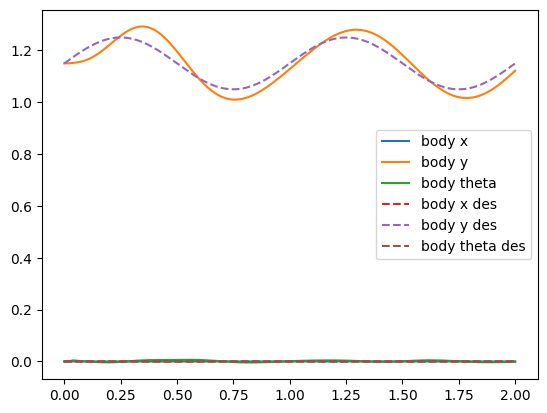

In [ ]:
keypoint_hist_np = np.array(result_wbc['keypoints_hist'])
print()
ax = plt.subplot()
ax.plot(ts, keypoint_hist_np[:, 0, 0], label='body x')
ax.plot(ts, keypoint_hist_np[:, 0, 1], label='body y')
ax.plot(ts, result_wbc['ori_hist'], label='body theta')
ax.plot(ts, x_des_trj[0, :], '--', label='body x des')
ax.plot(ts, x_des_trj[1, :], '--', label='body y des')
ax.plot(ts, x_des_trj[2, :], '--', label='body theta des')


ax.legend()
plt.show()

In [ ]:
anim = visualize_robot(result_wbc, dt = 0.001, num_frames=100)
plt.close()
HTML(anim.to_html5_video())


writervideo = animation.FFMpegWriter(fps=60)
anim.save('body_ctrl.mp4', writer=writervideo)

<ipython-input-6-98053b767229>:53: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  bodyCOM.set_data(keypts[0, 0], keypts[0, 1])
<ipython-input-6-98053b767229>:53: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  bodyCOM.set_data(keypts[0, 0], keypts[0, 1])
<ipython-input-6-98053b767229>:53: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  bodyCOM.set_data(keypts[0, 0], keypts[0, 1])
